In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
# Definição dos tipos de cômodos e suas dimensões possíveis
COMODOS = {
    "Quarto": (12, 30),
    "Banheiro": (3, 8),
    "Cozinha": (10, 15),
    "Sala de Estar": (30, 40),
    "Sala de Jantar": (15, 20),
    "Área de Serviço": (6, 10),
    "Sala de Jogos": (20, 30),
    "Closet": (3, 4),
}

# Definição das mobílias e suas dimensões (mantido do código anterior)
MOBILIAS = {
    "Sala de Estar": [
        ("Sofá 2 lugares", 0.82, 1.72),
        ("Sofá 3 lugares", 0.82, 2.10),
        ("Poltrona", 0.70, 0.80),
        ("Mesa de Centro", 1, 0.60),
        ("Mesa Auxiliar", 0.43, 0.40),
    ],
    "Sala de Jantar": [
        ("Mesa 4 lugares", 0.90, 0.90),
        ("Mesa 6 lugares", 1.60, 0.90),
        ("Aparador", 0.90, 0.36),
        ("Cristaleira", 0.34, 0.84),
    ],
    "Quarto": [
        ("Cama de Casal", 1.44, 1.93),
        ("Cama de Solteiro", 0.94, 1.93),
        ("Mesa Auxiliar", 0.43, 0.40),
        ("Guarda-Roupa 2 portas", 0.40, 1),
        ("Guarda-Roupa 3 portas", 0.40, 1.70),
        ("Gaveteiro", 0.40, 0.87),
    ],
    "Cozinha": [
        ("Fogão 4 bocas", 0.58, 0.68),
        ("Fogão 5 bocas", 0.77, 0.68),
        ("Geladeira 1 porta", 0.62, 0.75),
        ("Geladeira 2 portas", 0.83, 0.79),
        ("Armário", 0.34, 1.68),
        ("Pia", 1, 0.50),
    ],
    "Banheiro": [
        ("Vaso Sanitário", 0.37, 0.64),
        ("Banheira", 0.71, 1.65),
        ("Pia com Armário", 0.70, 0.45),
        ("Box", 1.5, 2),
    ],
    "Área de Serviço": [("Máquina de Lavar", 0.60, 0.65), ("Tanque", 0.52, 0.53)],
    "Sala de Jogos": [
        ("Mesa de Sinuca", 1.37, 2.44),
        ("Mesa de Ping Pong", 1.52, 2.74),
        ("Sofá", 0.82, 2.10),
        ("Estante", 0.40, 1.80),
    ],
}

In [3]:
class Comodo:
    def __init__(self, tipo, andar, x, y, largura, comprimento):
        self.tipo = tipo
        self.andar = andar
        self.x = x
        self.y = y
        self.largura = largura
        self.comprimento = comprimento
        self.portas = random.randint(1, 3)
        self.janelas = random.randint(1, 3)
        self.mobilias = self.gerar_mobilias_aleatorias()

    def gerar_mobilias_aleatorias(self):
        mobilias = []
        for mob in MOBILIAS.get(self.tipo, []):
            mob_largura, mob_comprimento = mob[1], mob[2]
            if mob_largura <= self.largura and mob_comprimento <= self.comprimento:
                posicao = (
                    random.uniform(0, self.largura - mob_largura),
                    random.uniform(0, self.comprimento - mob_comprimento),
                )
                mobilias.append(
                    {
                        "tipo": mob[0],
                        "largura": mob_largura,
                        "comprimento": mob_comprimento,
                        "posicao": posicao,
                    }
                )
        return mobilias

In [4]:
class Planta:
    def __init__(self, largura_casa, comprimento_casa, orientacao):
        self.largura_casa = largura_casa
        self.comprimento_casa = comprimento_casa
        self.orientacao = orientacao
        self.comodos = self.gerar_comodos_obrigatorios()
        self.fitness = self.calcular_fitness()

    def gerar_comodos_obrigatorios(self):
        comodos = []
        area_total = self.largura_casa * self.comprimento_casa
        area_usada = 0

        comodos_obrigatorios = [
            ("Cozinha", 0),
            ("Sala de Estar", 0),
            ("Sala de Jantar", 0),
            ("Área de Serviço", 0),
            ("Banheiro", 0),
            ("Sala de Jogos", 0),
            ("Quarto", 1),
            ("Quarto", 1),
            ("Quarto", 1),
            ("Banheiro", 1),
            ("Banheiro", 1),
            ("Closet", 1),
        ]

        for tipo, andar in comodos_obrigatorios:
            min_area, max_area = COMODOS[tipo]
            area = random.uniform(min_area, min(max_area, area_total - area_usada))

            # Tenta encontrar dimensões válidas
            for _ in range(100):  # Limite de tentativas
                largura = random.uniform(1, min(self.largura_casa, area))
                comprimento = area / largura
                if (
                    largura <= self.largura_casa
                    and comprimento <= self.comprimento_casa
                ):
                    break
            else:
                # Se não conseguir encontrar dimensões válidas, use as dimensões mínimas
                largura = min(min_area**0.5, self.largura_casa)
                comprimento = min(min_area / largura, self.comprimento_casa)

            x = random.uniform(0, max(0.1, self.largura_casa - largura))
            y = random.uniform(0, max(0.1, self.comprimento_casa - comprimento))

            comodos.append(Comodo(tipo, andar, x, y, largura, comprimento))
            area_usada += largura * comprimento

            if area_usada >= area_total:
                break

        return comodos

    def encontrar_melhor_localizacao(self, grade, area, tamanho_grade):
        altura_grade = len(grade)
        largura_grade = len(grade[0])
        celulas_alvo = int(area / (tamanho_grade**2))
        melhor_pontuacao = float("inf")
        melhor_localizacao = None

        for altura in range(1, min(altura_grade, int(celulas_alvo**0.5) + 1)):
            largura = celulas_alvo // altura
            if largura > largura_grade:
                continue

            for y in range(altura_grade - altura + 1):
                for x in range(largura_grade - largura + 1):
                    if self.area_esta_livre(grade, x, y, largura, altura):
                        pontuacao = abs(largura * altura - celulas_alvo)
                        if pontuacao < melhor_pontuacao:
                            melhor_pontuacao = pontuacao
                            melhor_localizacao = (x, y, largura, altura)

        return melhor_localizacao

    def area_esta_livre(self, grade, x, y, largura, altura):
        for i in range(y, y + altura):
            for j in range(x, x + largura):
                if i >= len(grade) or j >= len(grade[0]) or grade[i][j] == 1:
                    return False
        return True

    def calcular_fitness(self):
        fitness = 0
        fitness += self.avaliar_sobreposicao()
        fitness += self.avaliar_area_utilizada()
        fitness += self.avaliar_separacao()
        return fitness

    def avaliar_sobreposicao(self):
        for i, comodo1 in enumerate(self.comodos):
            for comodo2 in self.comodos[i + 1 :]:
                if (
                    comodo1.x < comodo2.x + comodo2.largura
                    and comodo1.x + comodo1.largura > comodo2.x
                    and comodo1.y < comodo2.y + comodo2.comprimento
                    and comodo1.y + comodo1.comprimento > comodo2.y
                    and comodo1.andar == comodo2.andar
                ):
                    return -100000  # Penalidade por sobreposição
        return 0

    def avaliar_area_utilizada(self):
        area_total = self.largura_casa * self.comprimento_casa
        area_utilizada = sum(c.largura * c.comprimento for c in self.comodos)
        return (area_utilizada / area_total) * 100  # Percentual de área utilizada

    def avaliar_separacao(self):
        areas_sociais = ["Sala de Estar", "Sala de Jantar", "Sala de Jogos"]
        areas_intimas = ["Quarto", "Banheiro", "Closet"]

        sociais_andar_0 = sum(
            1 for c in self.comodos if c.tipo in areas_sociais and c.andar == 0
        )
        intimas_andar_1 = sum(
            1 for c in self.comodos if c.tipo in areas_intimas and c.andar == 1
        )

        return 10 if sociais_andar_0 >= 2 and intimas_andar_1 >= 3 else 0

In [5]:
def selecao(populacao):
    selecionados = random.sample(populacao, 2)
    return max(selecionados, key=lambda p: p.fitness)


def cruzamento(pai1, pai2):
    filho = Planta(pai1.largura_casa, pai1.comprimento_casa, pai1.orientacao)
    filho.comodos = (
        pai1.comodos[: len(pai1.comodos) // 2] + pai2.comodos[len(pai2.comodos) // 2 :]
    )
    filho.fitness = filho.calcular_fitness()
    return filho


def mutacao(planta):
    comodo = random.choice(planta.comodos)
    comodo.x = random.uniform(0, max(0.1, planta.largura_casa - comodo.largura))
    comodo.y = random.uniform(0, max(0.1, planta.comprimento_casa - comodo.comprimento))
    planta.fitness = planta.calcular_fitness()


def ciclo_evolutivo(
    geracoes, tamanho_populacao, largura_casa, comprimento_casa, orientacao
):
    populacao = [
        Planta(largura_casa, comprimento_casa, orientacao)
        for _ in range(tamanho_populacao)
    ]
    for geracao in range(geracoes):
        # print(f"Geracao {geracao + 1}/{geracoes}")
        nova_populacao = []
        for _ in range(tamanho_populacao // 2):
            pai1 = selecao(populacao)
            pai2 = selecao(populacao)
            filho1 = cruzamento(pai1, pai2)
            filho2 = cruzamento(pai2, pai1)
            mutacao(filho1)
            mutacao(filho2)
            nova_populacao.extend([filho1, filho2])
        populacao = sorted(nova_populacao, key=lambda p: p.fitness, reverse=True)[
            :tamanho_populacao
        ]
    return populacao[0]


def desenhar_planta(planta):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    axes = [ax1, ax2]
    titles = ["Planta do Térreo", "Planta do Primeiro Andar"]

    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xlim(0, planta.largura_casa)
        ax.set_ylim(0, planta.comprimento_casa)
        ax.set_aspect("equal")

    cores = plt.cm.Set3(np.linspace(0, 1, len(COMODOS)))
    cor_mapa = dict(zip(COMODOS.keys(), cores))

    for comodo in planta.comodos:
        ax = axes[comodo.andar]
        retangulo = Rectangle(
            (comodo.x, comodo.y),
            comodo.largura,
            comodo.comprimento,
            fill=True,
            facecolor=cor_mapa[comodo.tipo],
            edgecolor="black",
            linewidth=2,
        )
        ax.add_patch(retangulo)
        ax.text(
            comodo.x + comodo.largura / 2,
            comodo.y + comodo.comprimento / 2,
            comodo.tipo,
            ha="center",
            va="center",
            wrap=True,
        )

        # Desenhar portas
        for _ in range(comodo.portas):
            porta_x = comodo.x + random.uniform(0, comodo.largura)
            porta_y = (
                comodo.y
                if random.choice([True, False])
                else comodo.y + comodo.comprimento
            )
            porta = Rectangle(
                (porta_x, porta_y),
                0.8,
                0.1,
                fill=True,
                facecolor="brown",
                edgecolor="black",
            )
            ax.add_patch(porta)

        # Desenhar janelas
        for _ in range(comodo.janelas):
            janela_x = comodo.x + random.uniform(0, comodo.largura)
            janela_y = (
                comodo.y
                if random.choice([True, False])
                else comodo.y + comodo.comprimento
            )
            janela = Rectangle(
                (janela_x, janela_y),
                1,
                0.1,
                fill=True,
                facecolor="lightblue",
                edgecolor="black",
            )
            ax.add_patch(janela)

        # Desenhar móveis
        for mobilia in comodo.mobilias:
            mob_x = comodo.x + mobilia["posicao"][0]
            mob_y = comodo.y + mobilia["posicao"][1]
            movel = Rectangle(
                (mob_x, mob_y),
                mobilia["largura"],
                mobilia["comprimento"],
                fill=True,
                facecolor="gray",
                edgecolor="black",
                alpha=0.5,
            )
            ax.add_patch(movel)

    # Adicionar orientação
    orientacao_texto = f"N\n^\n|\n \n{planta.orientacao}"
    for ax in axes:
        ax.text(
            1.02, 0.5, orientacao_texto, transform=ax.transAxes, va="center", ha="left"
        )

    plt.tight_layout()
    plt.show()

Bem-vindo ao gerador de plantas de casa!


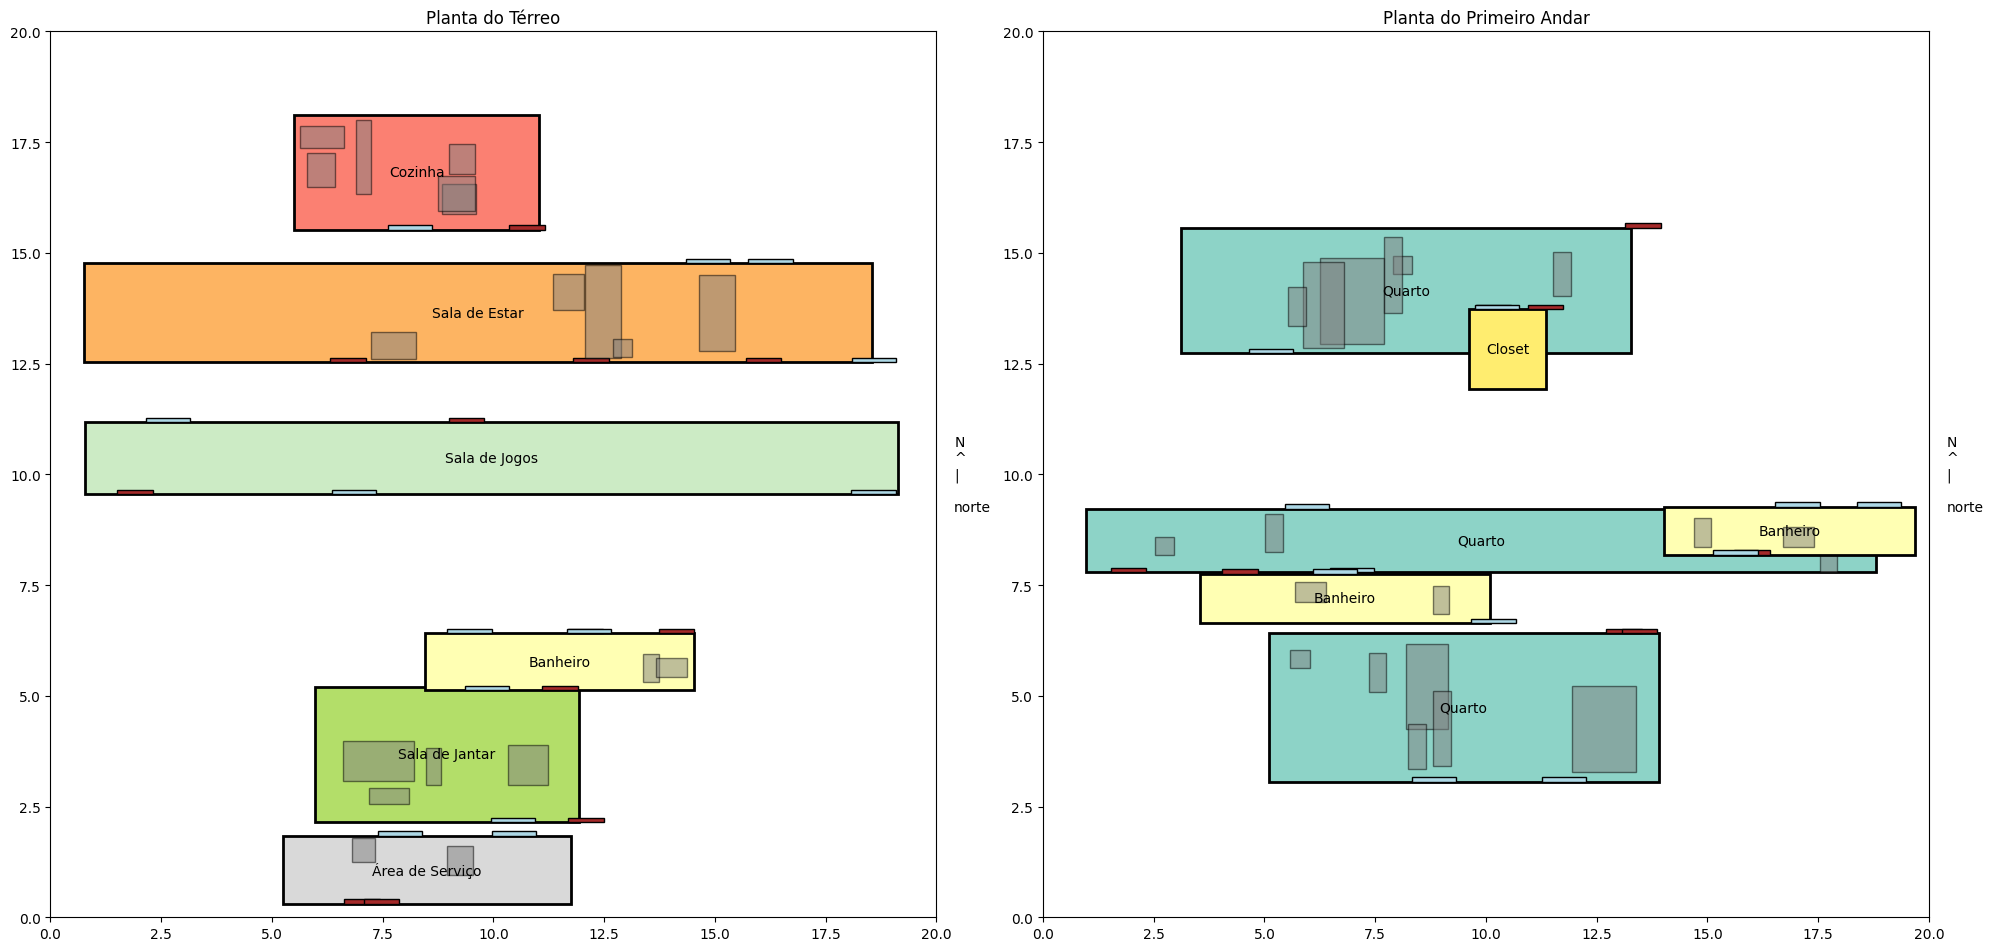


Informações da planta gerada:
Cômodo: Cozinha, Andar: 0
Posição: (5.50, 15.53)
Tamanho: 5.54m x 2.58m
Portas: 1, Janelas: 1
Mobília: Fogão 4 bocas, Tamanho: 0.58m x 0.68m, Posição: (3.506689586938976, 1.2453470719747577)
Mobília: Fogão 5 bocas, Tamanho: 0.77m x 0.68m, Posição: (3.346192435566056, 0.3426152097178333)
Mobília: Geladeira 1 porta, Tamanho: 0.62m x 0.75m, Posição: (0.3034661976240907, 0.9707229717227885)
Mobília: Geladeira 2 portas, Tamanho: 0.83m x 0.79m, Posição: (3.247496601475618, 0.41811103634725894)
Mobília: Armário, Tamanho: 0.34m x 1.68m, Posição: (1.3957097451493057, 0.7919206494900868)
Mobília: Pia, Tamanho: 1.00m x 0.50m, Posição: (0.13132648992915227, 1.846200647840029)

Cômodo: Sala de Estar, Andar: 0
Posição: (0.76, 12.54)
Tamanho: 17.80m x 2.23m
Portas: 3, Janelas: 3
Mobília: Sofá 2 lugares, Tamanho: 0.82m x 1.72m, Posição: (13.877150052164495, 0.2365598968390786)
Mobília: Sofá 3 lugares, Tamanho: 0.82m x 2.10m, Posição: (11.31513989602271, 0.093945588288780

In [6]:
# Interface do usuário
print("Bem-vindo ao gerador de plantas de casa!")
# largura = float(input("Digite a largura da casa em metros: "))
# comprimento = float(input("Digite o comprimento da casa em metros: "))
# orientacao = input("Digite a orientação da fachada (norte, sul, leste, oeste): ").lower()
largura = 20
comprimento = 20
orientacao = "norte"

# Verificar se a área total é suficiente
area_total = largura * comprimento
area_minima_necessaria = sum(min_area for min_area, _ in COMODOS.values())

if area_total < area_minima_necessaria:
    print(
        f"Erro: A área total da casa ({area_total:.2f} m²) é menor que a área mínima necessária ({area_minima_necessaria:.2f} m²)."
    )
    print("Por favor, forneça dimensões maiores para a casa.")
else:
    # Executar o algoritmo genético
    melhor_planta = ciclo_evolutivo(
        geracoes=100,
        tamanho_populacao=200,
        largura_casa=largura,
        comprimento_casa=comprimento,
        orientacao=orientacao,
    )

    # Desenhar a planta
    desenhar_planta(melhor_planta)

    # Exibir informações sobre a planta
    print("\nInformações da planta gerada:")
    for comodo in melhor_planta.comodos:
        print(f"Cômodo: {comodo.tipo}, Andar: {comodo.andar}")
        print(f"Posição: ({comodo.x:.2f}, {comodo.y:.2f})")
        print(f"Tamanho: {comodo.largura:.2f}m x {comodo.comprimento:.2f}m")
        print(f"Portas: {comodo.portas}, Janelas: {comodo.janelas}")
        for mob in comodo.mobilias:
            print(
                f"Mobília: {mob['tipo']}, Tamanho: {mob['largura']:.2f}m x {mob['comprimento']:.2f}m, Posição: {mob['posicao']}"
            )
        print()

    print(f"Fitness da planta: {melhor_planta.fitness}")